In [20]:
#dependencies 
import numpy as np
import pandas as pd

In [21]:
#import cleaned data csv
all_wells = pd.read_csv('Data/well_cleaned.csv')
all_wells

,Unnamed: 0,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE
0,15,NO 15/9-F-1 C,289.42,106.35,43.34,107.36,37.94,78.94,631.47,90439.09,0.00,production,OP
1,16,NO 15/9-F-1 C,270.24,107.64,47.17,99.19,60.76,70.63,1166.46,165720.39,0.00,production,OP
2,17,NO 15/9-F-1 C,262.84,107.87,47.73,94.60,63.05,66.05,1549.81,221707.31,0.00,production,OP
3,18,NO 15/9-F-1 C,255.53,107.97,48.53,89.99,64.55,61.41,1248.70,178063.52,0.00,production,OP
4,19,NO 15/9-F-1 C,247.20,108.05,49.84,84.78,65.72,56.15,1345.78,192602.19,0.00,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,8923,NO 15/9-F-15 D,194.98,106.52,31.58,15.81,49.02,1.26,144.01,23201.35,203.93,production,OP
5939,8924,NO 15/9-F-15 D,194.98,106.52,31.54,15.77,48.99,1.20,145.22,23068.07,202.93,production,OP
5940,8925,NO 15/9-F-15 D,194.32,106.52,31.52,15.70,50.10,1.28,142.74,23059.68,203.84,production,OP
5941,8926,NO 15/9-F-15 D,195.21,106.51,31.52,15.61,49.84,1.20,144.46,23090.47,202.76,production,OP


# Neural Network Analysis

### INPUTS: AVG_CHOKE_SIZE_P, AVG_WHP_P, AVG_WHT_P, BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL

In [22]:
#read in data for analysis 
X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
print(X1.shape)

(5943, 6)


In [23]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [25]:
#create the neural network
from tensorflow.keras.models import Sequential
model = Sequential()

In [26]:
#create the model
from tensorflow.keras.layers import Dense
number_inputs = X_train.shape[1]
number_hidden_nodes = 100

model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
model.add(Dense(number_hidden_nodes, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [27]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [28]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
#early stopping tuning #1
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,verbose=0, mode='min')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 1s - loss: 0.6295 - r_square: 0.2888 - rmse: 0.6295 - val_loss: 0.5027 - val_r_square: 0.4800 - val_rmse: 0.5027
Epoch 2/100
1263/1263 - 0s - loss: 0.4379 - r_square: 0.5815 - rmse: 0.4379 - val_loss: 0.3834 - val_r_square: 0.6321 - val_rmse: 0.3834
Epoch 3/100
1263/1263 - 0s - loss: 0.3392 - r_square: 0.7095 - rmse: 0.3392 - val_loss: 0.3203 - val_r_square: 0.6846 - val_rmse: 0.3203
Epoch 4/100
1263/1263 - 0s - loss: 0.2806 - r_square: 0.7715 - rmse: 0.2806 - val_loss: 0.2980 - val_r_square: 0.6926 - val_rmse: 0.2980
Epoch 5/100
1263/1263 - 0s - loss: 0.2442 - r_square: 0.8188 - rmse: 0.2442 - val_loss: 0.2839 - val_r_square: 0.6923 - val_rmse: 0.2839
Epoch 6/100
1263/1263 - 0s - loss: 0.2244 - r_square: 0.8215 - rmse: 0.2244 - val_loss: 0.2767 - val_r_square: 0.6800 - val_rmse: 0.2767
Epoch 7/100
1263/1263 - 0s - loss: 0.2203 - r_square: 0.8315 - rmse: 0.2203 - val_loss: 0.2647 - val_r_square: 0.6862 - val_rmse: 0

In [31]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 21us/sample - loss: 0.1491 - r_square: 0.8638 - rmse: 0.1491


[0.1491281768334666, 0.86377335, 0.14912818]

In [32]:
#early stopping tuning #2
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_r_square', min_delta=0.000001, patience=5,verbose=0, mode='max')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 0s - loss: 0.1374 - r_square: 0.9003 - rmse: 0.1374 - val_loss: 0.1968 - val_r_square: 0.6748 - val_rmse: 0.1968
Epoch 2/100
1263/1263 - 0s - loss: 0.1350 - r_square: 0.8948 - rmse: 0.1350 - val_loss: 0.1882 - val_r_square: 0.6859 - val_rmse: 0.1882
Epoch 3/100
1263/1263 - 0s - loss: 0.1351 - r_square: 0.9055 - rmse: 0.1351 - val_loss: 0.1986 - val_r_square: 0.6768 - val_rmse: 0.1986
Epoch 4/100
1263/1263 - 0s - loss: 0.1376 - r_square: 0.9022 - rmse: 0.1376 - val_loss: 0.1898 - val_r_square: 0.6879 - val_rmse: 0.1898
Epoch 5/100
1263/1263 - 0s - loss: 0.1375 - r_square: 0.9036 - rmse: 0.1375 - val_loss: 0.2024 - val_r_square: 0.6869 - val_rmse: 0.2024
Epoch 6/100
1263/1263 - 0s - loss: 0.1358 - r_square: 0.9087 - rmse: 0.1358 - val_loss: 0.1878 - val_r_square: 0.6912 - val_rmse: 0.1878
Epoch 7/100
1263/1263 - 0s - loss: 0.1298 - r_square: 0.9048 - rmse: 0.1298 - val_loss: 0.2033 - val_r_square: 0.6876 - val_rmse: 0

1263/1263 - 0s - loss: 0.1186 - r_square: 0.9251 - rmse: 0.1186 - val_loss: 0.1772 - val_r_square: 0.7918 - val_rmse: 0.1772
Epoch 61/100
1263/1263 - 0s - loss: 0.1158 - r_square: 0.9237 - rmse: 0.1158 - val_loss: 0.1717 - val_r_square: 0.7905 - val_rmse: 0.1717
Epoch 62/100
1263/1263 - 0s - loss: 0.1156 - r_square: 0.9227 - rmse: 0.1156 - val_loss: 0.1730 - val_r_square: 0.7928 - val_rmse: 0.1730
Epoch 63/100
1263/1263 - 0s - loss: 0.1170 - r_square: 0.9204 - rmse: 0.1170 - val_loss: 0.1848 - val_r_square: 0.7883 - val_rmse: 0.1848
Epoch 64/100
1263/1263 - 0s - loss: 0.1164 - r_square: 0.9165 - rmse: 0.1164 - val_loss: 0.1755 - val_r_square: 0.7901 - val_rmse: 0.1755
Epoch 65/100
1263/1263 - 0s - loss: 0.1138 - r_square: 0.9223 - rmse: 0.1138 - val_loss: 0.1713 - val_r_square: 0.7948 - val_rmse: 0.1713
Epoch 66/100
1263/1263 - 0s - loss: 0.1157 - r_square: 0.9289 - rmse: 0.1157 - val_loss: 0.1777 - val_r_square: 0.7879 - val_rmse: 0.1777
Epoch 67/100
1263/1263 - 0s - loss: 0.1191 - r_

In [33]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 33us/sample - loss: 0.1162 - r_square: 0.9078 - rmse: 0.1162


[0.11616962148355443, 0.90783346, 0.11616962]

# Hyperas Tuning


In [34]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [35]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [36]:
#function to scale data for create model function
def data():
    #read in data for analysis 
    all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
    X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
    y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
    #split into test and train data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
    from sklearn.preprocessing import StandardScaler
    # # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # # Transform the training and testing data using the X_scaler and y_scaler models
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train = X_train_scaled.reshape(-1,6)
    x_test = X_test_scaled.reshape(-1,6)
    y_train = y_train_scaled.reshape(-1,1)
    y_test = y_test_scaled.reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [37]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [38]:
#defining the create model function
exec('from __future__ import absolute_import, division, print_function')
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras import backend as K

def create_model(x_train, y_train, x_test, y_test):
    print(x_train.shape)
    model= Sequential() 
    model.add(Dense({{choice([50,200,500])}}, input_dim=x_train.shape[1], activation= 'relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense({{choice([50,200,500])}},activation= 'relu'))
    #model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense(1, activation= 'linear'))

    
################################################
# CREDIT: https://github.com/keras-team/keras/issues/7947
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
    def mse(y_true, y_pred):
        from keras import backend
        return backend.mean(backend.square(y_pred - y_true), axis=-1)
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#############################################

    model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[r_square, rmse])
    from keras.utils import print_summary
    print_summary(model, line_length=None, positions=None, print_fn=None)
    result= model.fit(x_train, y_train,
                      batch_size={{choice([64,128])}},
                      epochs={{choice([50,100,150])}},
                      verbose=2,
                      validation_split =0.15)
    validation_acc= np.min(result.history['val_loss'])
    print('Lowest Validation Loss:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}   

#finding the best model
best_run, best_model= optim.minimize(model=create_model,
                                     data=data,
                                     algo=tpe.suggest,
                                     max_evals=5,
                                     trials=Trials(),
                                     eval_space=True,
                                     notebook_name='NeuralAnalysis')
score= best_model.evaluate(X_test_scaled,y_test_scaled, batch_size= 64)

#predictions = best_model.predict(X_test_scaled)

#print best model results
print('Evaluate:', score[0])
#print('Predictions:', predictions[:6])
print('Best Performing Model:', best_run)


>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import losses
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:


Epoch 34/150                                                                                                           
 - 0s - loss: 0.2989 - r_square: 0.7681 - rmse: 0.2989 - val_loss: 0.2553 - val_r_square: 0.8344 - val_rmse: 0.2553    

Epoch 35/150                                                                                                           
 - 0s - loss: 0.2913 - r_square: 0.7669 - rmse: 0.2913 - val_loss: 0.2709 - val_r_square: 0.8228 - val_rmse: 0.2709    

Epoch 36/150                                                                                                           
 - 0s - loss: 0.2928 - r_square: 0.7678 - rmse: 0.2928 - val_loss: 0.2463 - val_r_square: 0.8423 - val_rmse: 0.2463    

Epoch 37/150                                                                                                           
 - 0s - loss: 0.2914 - r_square: 0.7781 - rmse: 0.2914 - val_loss: 0.2550 - val_r_square: 0.8378 - val_rmse: 0.2550    

Epoch 38/150                        

Epoch 101/150                                                                                                          
 - 0s - loss: 0.2642 - r_square: 0.8028 - rmse: 0.2642 - val_loss: 0.2441 - val_r_square: 0.8456 - val_rmse: 0.2441    

Epoch 102/150                                                                                                          
 - 0s - loss: 0.2643 - r_square: 0.8087 - rmse: 0.2643 - val_loss: 0.2463 - val_r_square: 0.8470 - val_rmse: 0.2463    

Epoch 103/150                                                                                                          
 - 0s - loss: 0.2672 - r_square: 0.7957 - rmse: 0.2672 - val_loss: 0.2514 - val_r_square: 0.8418 - val_rmse: 0.2514    

Epoch 104/150                                                                                                          
 - 0s - loss: 0.2656 - r_square: 0.8010 - rmse: 0.2656 - val_loss: 0.2562 - val_r_square: 0.8352 - val_rmse: 0.2562    

Epoch 105/150                       

 - 0s - loss: 0.4885 - r_square: 0.5352 - rmse: 0.4885 - val_loss: 0.4351 - val_r_square: 0.6605 - val_rmse: 0.4351    

Epoch 6/50                                                                                                             
 - 0s - loss: 0.4644 - r_square: 0.5665 - rmse: 0.4644 - val_loss: 0.4314 - val_r_square: 0.6680 - val_rmse: 0.4314    

Epoch 7/50                                                                                                             
 - 0s - loss: 0.4485 - r_square: 0.5960 - rmse: 0.4485 - val_loss: 0.3954 - val_r_square: 0.6995 - val_rmse: 0.3954    

Epoch 8/50                                                                                                             
 - 0s - loss: 0.4511 - r_square: 0.5829 - rmse: 0.4511 - val_loss: 0.3909 - val_r_square: 0.7135 - val_rmse: 0.3909    

Epoch 9/50                                                                                                             
 - 0s - loss: 0.4417 - r_square: 0.5

 - 0s - loss: 0.7332 - r_square: 0.0795 - rmse: 0.7332 - val_loss: 0.7427 - val_r_square: 0.1216 - val_rmse: 0.7427    

Epoch 11/100                                                                                                           
 - 0s - loss: 0.7218 - r_square: 0.1101 - rmse: 0.7218 - val_loss: 0.7411 - val_r_square: 0.1282 - val_rmse: 0.7411    

Epoch 12/100                                                                                                           
 - 0s - loss: 0.7201 - r_square: 0.1054 - rmse: 0.7201 - val_loss: 0.7431 - val_r_square: 0.1219 - val_rmse: 0.7431    

Epoch 13/100                                                                                                           
 - 0s - loss: 0.7174 - r_square: 0.1074 - rmse: 0.7174 - val_loss: 0.7506 - val_r_square: 0.1083 - val_rmse: 0.7506    

Epoch 14/100                                                                                                           
 - 0s - loss: 0.7165 - r_square: 0.1

 - 0s - loss: 0.6524 - r_square: 0.1684 - rmse: 0.6524 - val_loss: 0.7906 - val_r_square: 0.0064 - val_rmse: 0.7906    

Epoch 78/100                                                                                                           
 - 0s - loss: 0.6512 - r_square: 0.2147 - rmse: 0.6512 - val_loss: 0.7931 - val_r_square: 0.0014 - val_rmse: 0.7931    

Epoch 79/100                                                                                                           
 - 0s - loss: 0.6506 - r_square: 0.2145 - rmse: 0.6506 - val_loss: 0.7925 - val_r_square: 0.0038 - val_rmse: 0.7925    

Epoch 80/100                                                                                                           
 - 0s - loss: 0.6452 - r_square: 0.2275 - rmse: 0.6452 - val_loss: 0.7917 - val_r_square: 0.0059 - val_rmse: 0.7917    

Epoch 81/100                                                                                                           
 - 0s - loss: 0.6470 - r_square: 0.2

Epoch 34/100                                                                                                           
 - 0s - loss: 0.3312 - r_square: 0.7374 - rmse: 0.3312 - val_loss: 0.2298 - val_r_square: 0.8461 - val_rmse: 0.2298    

Epoch 35/100                                                                                                           
 - 0s - loss: 0.3308 - r_square: 0.7362 - rmse: 0.3308 - val_loss: 0.2237 - val_r_square: 0.8466 - val_rmse: 0.2237    

Epoch 36/100                                                                                                           
 - 0s - loss: 0.3287 - r_square: 0.7368 - rmse: 0.3287 - val_loss: 0.2274 - val_r_square: 0.8452 - val_rmse: 0.2274    

Epoch 37/100                                                                                                           
 - 0s - loss: 0.3255 - r_square: 0.7439 - rmse: 0.3255 - val_loss: 0.2302 - val_r_square: 0.8488 - val_rmse: 0.2302    

Epoch 38/100                        

Lowest Validation Loss:                                                                                                
0.20280466334523997                                                                                                    
(4457, 6)                                                                                                              
Model: "sequential_5"                                                                                                  
_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
dense_13 (Dense)             (None, 500)               3500                                                            
_________________________________________________________________                                                      
dropout_9 (Dropout)          (None, 500)

In [42]:
#using model to predict y values
predictions = best_model.predict(X_test_scaled)
predictions1 = best_model.predict(X_train_scaled)
predictions1
#predictions= test
#predictions1= train 


array([[ 0.11042935],
       [-0.02757291],
       [ 0.08504621],
       ...,
       [-0.08176664],
       [-0.07878926],
       [-0.07380855]], dtype=float32)

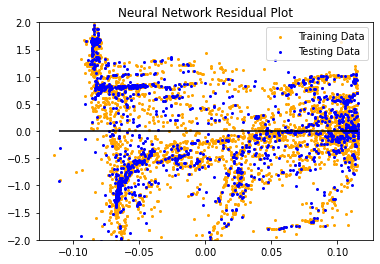

In [43]:
# Plot Residuals
import matplotlib.pyplot as plt

plt.title('Neural Network Residual Plot')
plt.scatter(predictions1, predictions1 - y_train_scaled, c= "orange",label="Training Data", s=4)
plt.scatter(predictions, predictions - y_test_scaled, c= "blue",label="Testing Data",s=4)
plt.ylim(-2,2)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.legend()

plt.savefig('neuralnetworkresidual.png')
plt.show()